# Hexagon dataset evaluation

## Number of epochs
I will try to find on how many epochs should I train the network.

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from som import KohonenNetwork, GaussianNeighboringFunc
import pickle

from sklearn.metrics import davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score, calinski_harabasz_score

In [3]:
data_dir = Path("data")

cube = pd.read_csv(data_dir / "cube.csv")
hexagon = pd.read_csv(data_dir / "hexagon.csv")

Text(0.5, 1.0, 'Original clusters in the hexagon dataset')

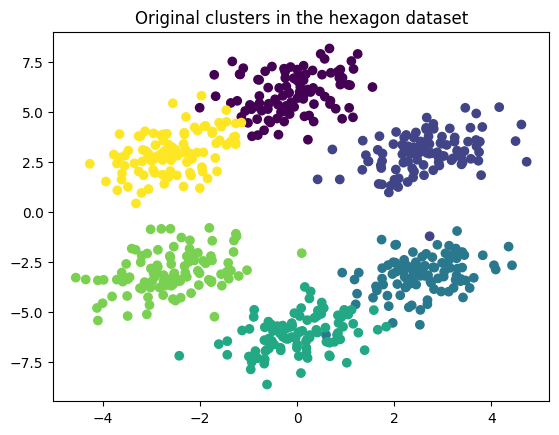

In [9]:
plt.scatter(hexagon["x"], hexagon["y"], c=hexagon["c"])
plt.title("Original clusters in the hexagon dataset")


using 6 clusters I will train the network with default parameters to determine the network performance on different epochs. I will use the *Davies-Bouldin*, *homogenity* and *completness* and visuall assesement to do so.

In [4]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

In [5]:
M = 2
N = 3

max_epochs = 200
n_trials = 10


In [101]:

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=1, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))



Trail 0
Finished training in trail 0
Trail 1
Finished training in trail 1
Trail 2
Finished training in trail 2
Trail 3
Finished training in trail 3
Trail 4
Finished training in trail 4
Trail 5
Finished training in trail 5
Trail 6
Finished training in trail 6
Trail 7
Finished training in trail 7
Trail 8
Finished training in trail 8
Trail 9
Finished training in trail 9


In [8]:
def save_scores(scores, filename):
    with open(Path("scores") / (filename + ".pkl"), "wb") as f:
        pickle.dump(scores, f)

def load_scores(filename):
    with open(Path("scores") / (filename + ".pkl"), "rb") as f:
        return pickle.load(f)
    

In [5]:
test_name = "epochs_lambda_1"
# save_scores(scores, test_name)

In [10]:
scores = load_scores("epochs_lambda_1")

In [11]:
labels = koh.predict(hexagon[["x", "y"]].values)
plt.scatter(hexagon["x"], hexagon["y"], c=labels)
koh.plot_graph()

NameError: name 'koh' is not defined

In [11]:
def create_summary_plots(scores, values, scores_start = 0, scores_end = -1, errorbar = True, errorevery=10, plot_title = "", suptitle="", save_path=None, baseline = True, n_trials = 10):
    if scores_end == -1:
        scores_end = scores_start + len(values) - 1
    
    mean_scores = {key: np.mean([scores[trail][key] for trail in range(n_trials)], axis=0) for key in scores[0].keys()}
    std_scores = {key: np.std([scores[trail][key] for trail in range(n_trials)], axis=0) for key in scores[0].keys()}

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    if errorbar:
        axs[0].errorbar(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end], yerr = std_scores["homogeneity"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[0].set_title("Homogeneity")
        axs[1].errorbar(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end], yerr = std_scores["completeness"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[1].set_title("Completeness")

        axs[2].errorbar(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end], yerr = std_scores["davies_bouldin"][scores_start:scores_end], label="SOM clustering", errorevery = errorevery); axs[2].set_title("Davies-Bouldin score")
    else:
        axs[0].plot(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end], label="SOM clustering"); axs[0].set_title("Homogeneity")
        axs[1].plot(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end], label="SOM clustering"); axs[1].set_title("Completeness")
        axs[2].plot(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end], label="SOM clustering"); axs[2].set_title("Davies-Bouldin")
        
        axs[0].fill_between(values[scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end] - std_scores["homogeneity"][scores_start:scores_end], mean_scores["homogeneity"][scores_start:scores_end] + std_scores["homogeneity"][scores_start:scores_end], alpha=0.2)
        axs[1].fill_between(values[scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end] - std_scores["completeness"][scores_start:scores_end], mean_scores["completeness"][scores_start:scores_end] + std_scores["completeness"][scores_start:scores_end], alpha=0.2)
        axs[2].fill_between(values[scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end] - std_scores["davies_bouldin"][scores_start:scores_end], mean_scores["davies_bouldin"][scores_start:scores_end] + std_scores["davies_bouldin"][scores_start:scores_end], alpha=0.2)
        
    if baseline:
        axs[2].axhline(davies_bouldin_score(hexagon[['x', 'y']].values, hexagon["c"].values), c="red", label="Original clustering")
        
        
    for j in range(3):
            
            axs[j].set_xlabel(plot_title)
            axs[j].set_ylabel("Score")
            axs[j].legend()


    plt.suptitle(suptitle)
    
    if save_path:
        plt.savefig(Path("plots") / (save_path + ".png"))  
    return fig, axs
    

(<Figure size 1500x700 with 3 Axes>,
 array([<Axes: title={'center': 'Homogeneity'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Completeness'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Davies-Bouldin'}, xlabel='Epoch', ylabel='Score'>],
       dtype=object))

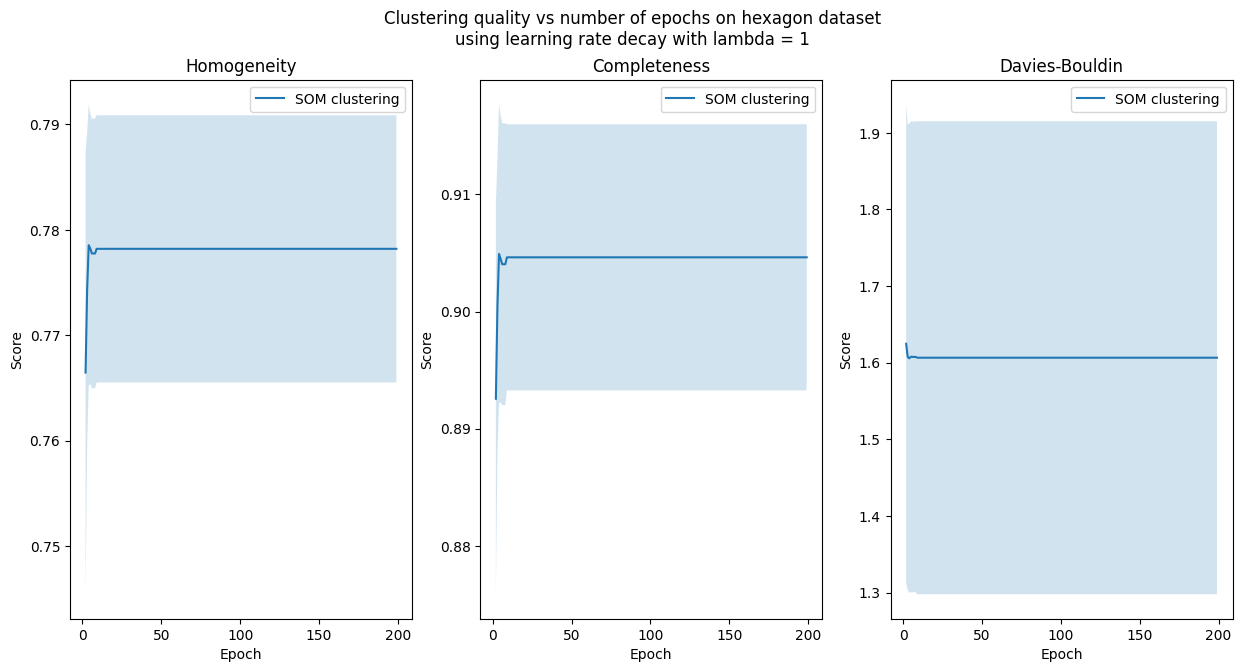

In [20]:
max_epochs = 200
create_summary_plots(scores, list(range(1, max_epochs)), scores_start = 1, errorbar=False, baseline=False, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on hexagon dataset\nusing learning rate decay with lambda = 1", save_path=test_name)

In [108]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=5, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))


Trail 0
Finished training in trail 0
Trail 1
Finished training in trail 1
Trail 2
Finished training in trail 2
Trail 3
Finished training in trail 3
Trail 4
Finished training in trail 4
Trail 5
Finished training in trail 5
Trail 6
Finished training in trail 6
Trail 7
Finished training in trail 7
Trail 8
Finished training in trail 8
Trail 9
Finished training in trail 9


In [21]:
# save_scores(scores, "epochs_lambda_5")
scores = load_scores("epochs_lambda_5")

(<Figure size 1500x700 with 3 Axes>,
 array([<Axes: title={'center': 'Homogeneity'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Completeness'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Davies-Bouldin'}, xlabel='Epoch', ylabel='Score'>],
       dtype=object))

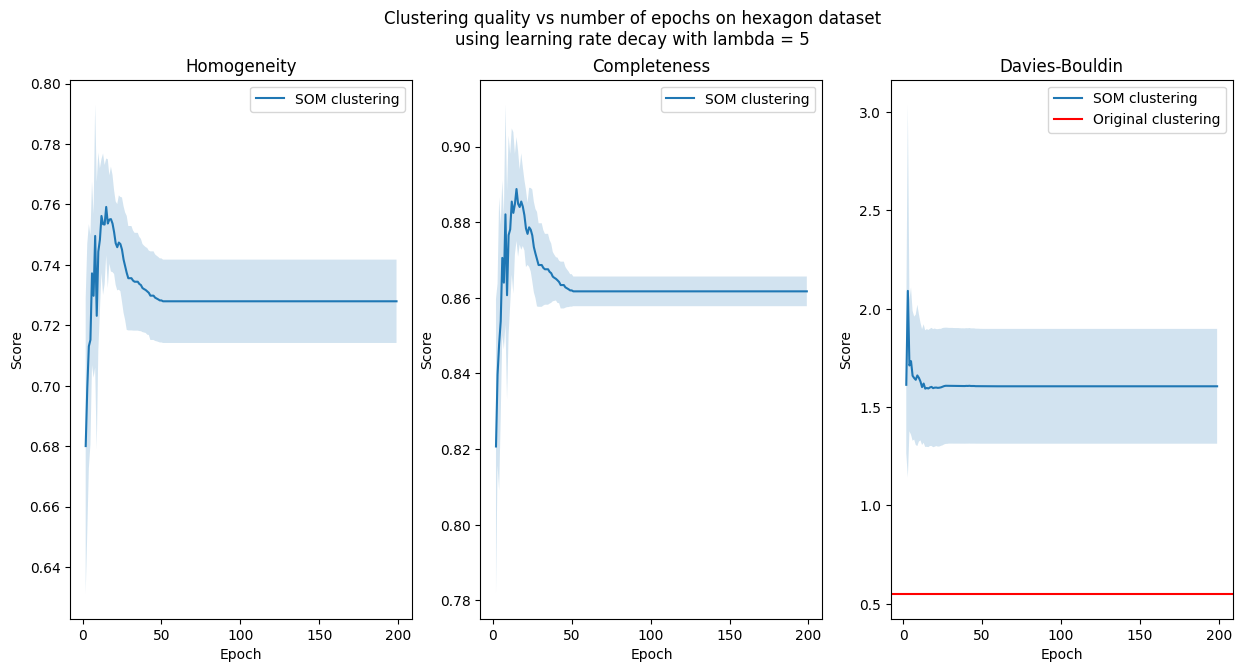

In [26]:
create_summary_plots(scores, list(range(1, max_epochs)), scores_start = 1, errorbar=False, baseline=True, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on hexagon dataset\nusing learning rate decay with lambda = 5", save_path="epochs_lambda_5")

In [111]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=10, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))


save_scores(scores, "epochs_lambda_10")


Trail 0
Finished training in trail 0
Trail 1
Finished training in trail 1
Trail 2
Finished training in trail 2
Trail 3
Finished training in trail 3
Trail 4
Finished training in trail 4
Trail 5
Finished training in trail 5
Trail 6
Finished training in trail 6
Trail 7
Finished training in trail 7
Trail 8
Finished training in trail 8
Trail 9
Finished training in trail 9


In [27]:
scores = load_scores("epochs_lambda_10")

[{'homogeneity': [0.6157819388124255,
   0.6487952617391819,
   0.7389776210436315,
   0.7433977372045697,
   0.5642145406102745,
   0.761815249400155,
   0.7456994479541289,
   0.6494377318653878,
   0.6313115361558291,
   0.7256386386746779,
   0.5980366216938406,
   0.7315651979805919,
   0.6556756492701138,
   0.7576614566059435,
   0.7620061700974652,
   0.6169379695786512,
   0.6828299687007747,
   0.7485749408981152,
   0.6466694991957838,
   0.7438917984369154,
   0.7636442781048874,
   0.7263482085147263,
   0.7592743498826587,
   0.7653817364704051,
   0.7512174465053297,
   0.7388822677026392,
   0.7203777227613838,
   0.7249501534900347,
   0.7084632884124495,
   0.7087961169036324,
   0.7289225773726776,
   0.7385384718069631,
   0.7128559832920824,
   0.7252450762365648,
   0.736659408973052,
   0.7204766557101028,
   0.7223841455742108,
   0.7215215600984713,
   0.7449526988997088,
   0.717584745811713,
   0.7122777917766265,
   0.7211235616375814,
   0.7173964724348834,

(<Figure size 1500x700 with 3 Axes>,
 array([<Axes: title={'center': 'Homogeneity'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Completeness'}, xlabel='Epoch', ylabel='Score'>,
        <Axes: title={'center': 'Davies-Bouldin'}, xlabel='Epoch', ylabel='Score'>],
       dtype=object))

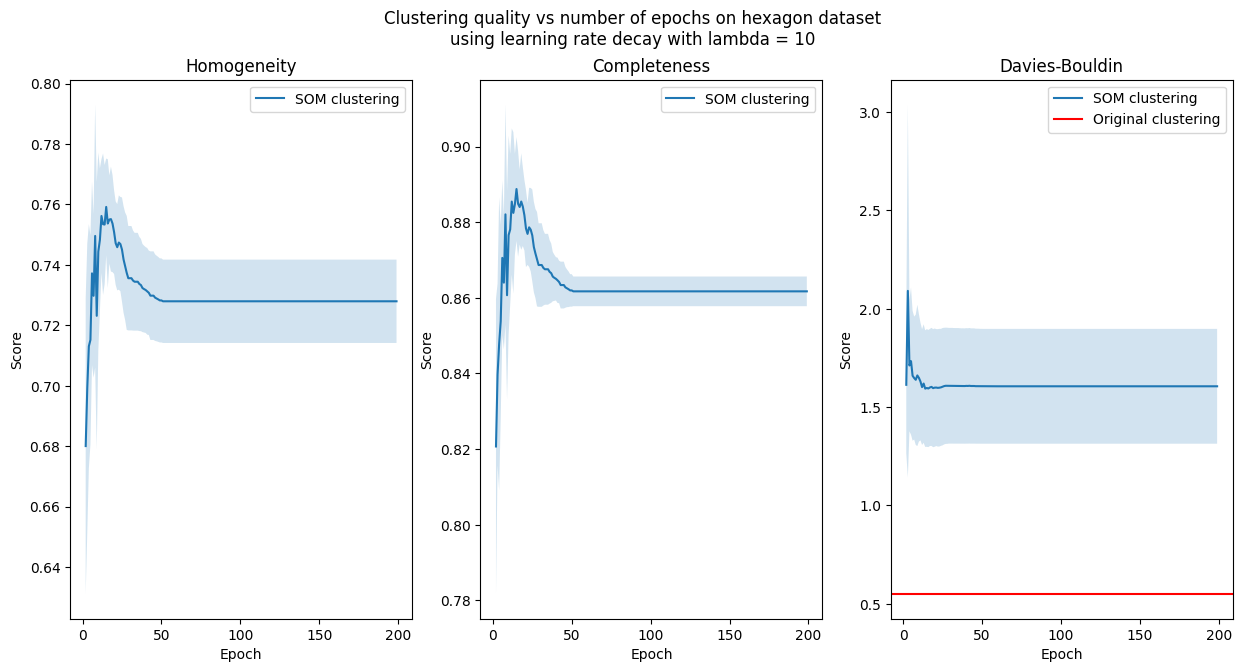

In [29]:
create_summary_plots(scores, list(range(1, max_epochs)), scores_start = 1, errorbar=False, baseline=True, plot_title="Epoch", suptitle="Clustering quality vs number of epochs on hexagon dataset\nusing learning rate decay with lambda = 10", save_path="epochs_lambda_10")

# Cluster size

In [32]:
import math

def closestDivisors(n):
    a = round(math.sqrt(n))
    while n%a > 0: a -= 1
    return a,n//a

In [33]:
cluster_sizes = [4, 6, 8, 10, 14, 20, 30]
cluster_dims = [closestDivisors(size) for size in cluster_sizes]
cluster_dims

[(2, 2), (2, 3), (2, 4), (2, 5), (2, 7), (4, 5), (5, 6)]

In [46]:
num_trails = 10
scores = list(range(num_trails))
labels = hexagon["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for dim in cluster_dims:
        size = dim[0] * dim[1]
        epochs = 10 * size
        koh = KohonenNetwork(dim[0], dim[1], GaussianNeighboringFunc(initial_neighbouring_radius=0.5), vec_dim=2)    
        koh.fit(hexagon[["x", "y"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(hexagon[["x", "y"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))
        
        
save_scores(scores, "cluster_sizes")

Trail 0
Trail 1
Trail 2
Trail 3
Trail 4
Trail 5
Trail 6
Trail 7
Trail 8
Trail 9


In [59]:
#save_scores(scores, "cluster_sizes")
scores = load_scores("cluster_sizes")

In [60]:
len(scores[0]["homogeneity"])

7

In [61]:
scores[0]["homogeneity"]

[0.3998410650746771,
 0.7118627428260026,
 0.8618922932995495,
 0.8152187822322882,
 0.7633708229234237,
 0.8440094979417434,
 0.8704358061773644]

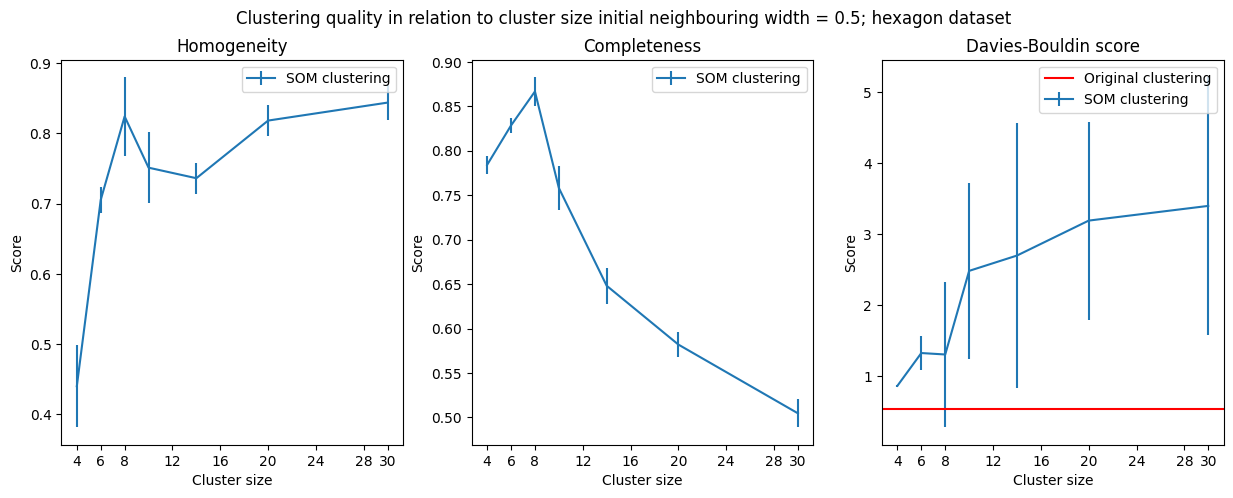

In [64]:
fig, axs = create_summary_plots(scores, cluster_sizes, scores_start = 0, scores_end=7, n_trials=10, errorevery=1, baseline=True, plot_title="Cluster size", suptitle="Clustering quality in relation to cluster size initial neighbouring width = 0.5; hexagon dataset", save_path="cluster_sizes_05")

for j in range(3):
        pass
        #axs[i, j].axvline(6, c="green")
        axs[j].set_xticks([4, 6, 8, 12, 16, 20, 24, 28, 30])
plt.show()

In [65]:
num_trails = 10
scores = list(range(num_trails))
labels = hexagon["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for dim in cluster_dims:
        size = dim[0] * dim[1]
        epochs = 10 * size
        koh = KohonenNetwork(dim[0], dim[1], GaussianNeighboringFunc(initial_neighbouring_radius=0.25), vec_dim=2)    
        koh.fit(hexagon[["x", "y"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(hexagon[["x", "y"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels)) 
save_scores(scores, "cluster_sizes_025")

Trail 0
Trail 1
Trail 2
Trail 3
Trail 4
Trail 5
Trail 6
Trail 7
Trail 8
Trail 9


In [67]:
scores = load_scores("cluster_sizes_025")

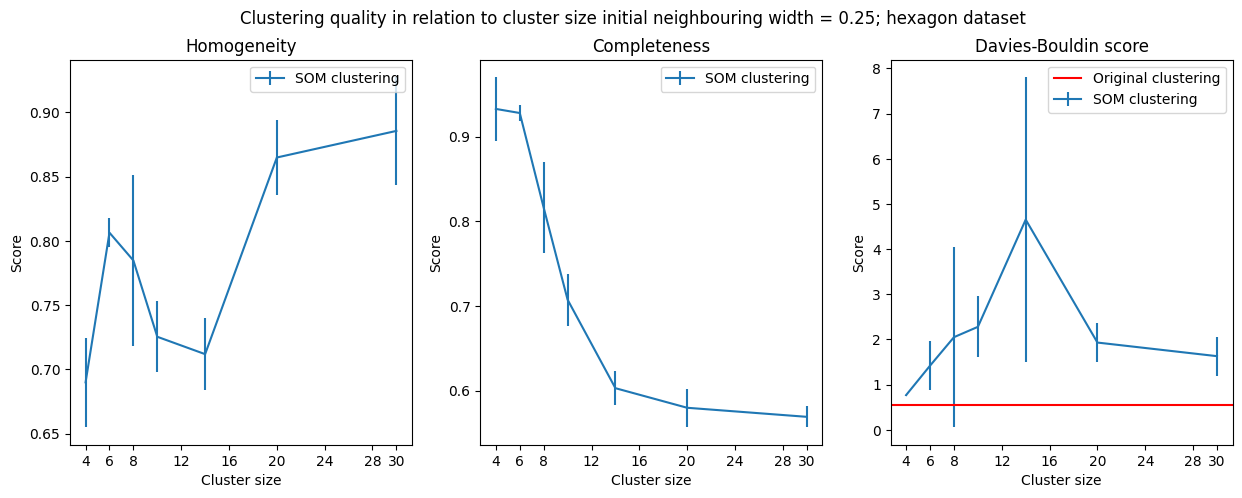

In [68]:
fig, axs = create_summary_plots(scores, cluster_sizes, scores_start = 0, scores_end=7, n_trials=10, errorevery=1, baseline=True, plot_title="Cluster size", suptitle="Clustering quality in relation to cluster size initial neighbouring width = 0.25; hexagon dataset", save_path="cluster_sizes_025")

for i in range(2):
    for j in range(3):
        #axs[i, j].axvline(6, c="green")
        axs[j].set_xticks([4, 6, 8, 12, 16, 20, 24, 28, 30])
plt.show()

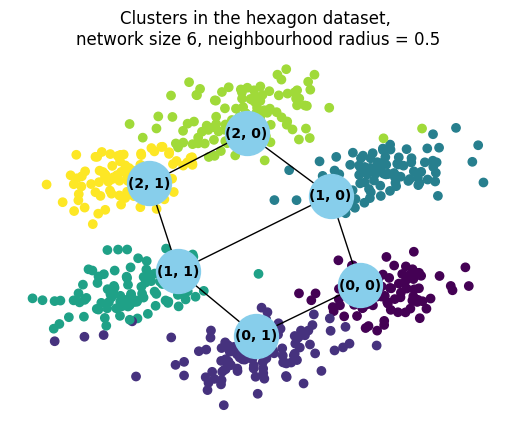

In [5]:

koh = KohonenNetwork(3, 2, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=1, initial_learning_rate=1, init_method="dataset", dataset=hexagon[["x", "y"]].values)

koh.fit(hexagon[["x", "y"]].values, 60, verbose=False)

labels = koh.predict(hexagon[["x", "y"]].values)


plt.scatter(hexagon["x"], hexagon["y"], c=labels)
plt.title("Clusters in the hexagon dataset, \nnetwork size 6, neighbourhood radius = 0.5")
koh.plot_graph(show=False)
plt.savefig("plots/hexagon_6_clusters.png")


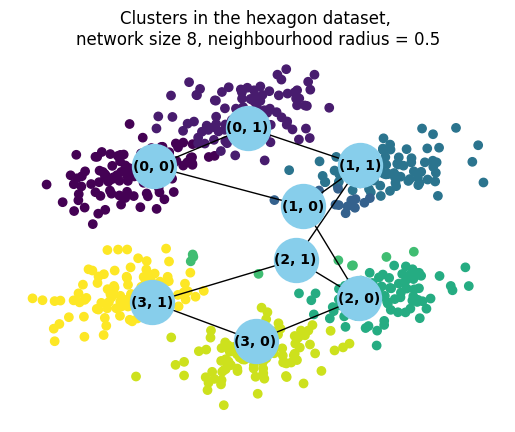

In [6]:

koh = KohonenNetwork(4, 2, GaussianNeighboringFunc(initial_neighbouring_radius=0.5), lambda_param=1, initial_learning_rate=1, init_method="dataset", dataset=hexagon[["x", "y"]].values)

koh.fit(hexagon[["x", "y"]].values, 80, verbose=False)

labels = koh.predict(hexagon[["x", "y"]].values)


plt.scatter(hexagon["x"], hexagon["y"], c=labels)
plt.title("Clusters in the hexagon dataset, \nnetwork size 8, neighbourhood radius = 0.5")
koh.plot_graph(show=False)
plt.savefig("plots/hexagon_8_clusters.png")


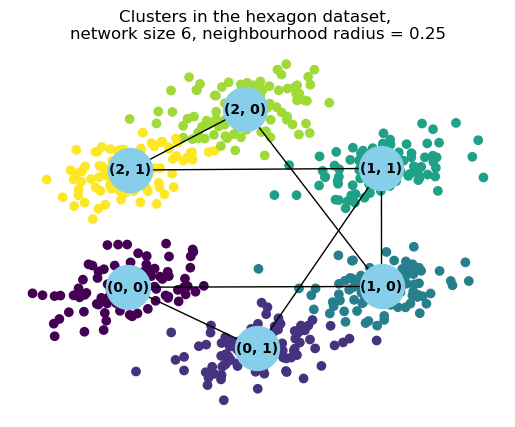

<Figure size 640x480 with 0 Axes>

In [33]:

koh = KohonenNetwork(3, 2, GaussianNeighboringFunc(initial_neighbouring_radius=0.25), lambda_param=1, initial_learning_rate=1, init_method="dataset", dataset=hexagon[["x", "y"]].values)

koh.fit(hexagon[["x", "y"]].values, 60, verbose=False)

labels = koh.predict(hexagon[["x", "y"]].values)


plt.scatter(hexagon["x"], hexagon["y"], c=labels)
plt.title("Clusters in the hexagon dataset, \nnetwork size 6, neighbourhood radius = 0.25")
koh.plot_graph()
plt.savefig("plots/hexagon_6_clusters_025.png")

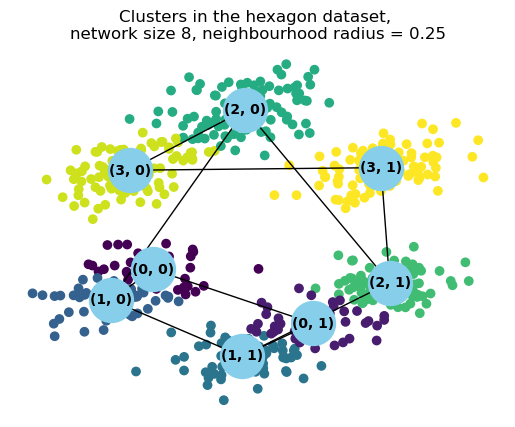

In [34]:

koh = KohonenNetwork(4, 2, GaussianNeighboringFunc(initial_neighbouring_radius=0.25), lambda_param=1, initial_learning_rate=1, init_method="dataset", dataset=hexagon[["x", "y"]].values)

koh.fit(hexagon[["x", "y"]].values, 80, verbose=False)

labels = koh.predict(hexagon[["x", "y"]].values)


plt.scatter(hexagon["x"], hexagon["y"], c=labels)
plt.title("Clusters in the hexagon dataset, \nnetwork size 8, neighbourhood radius = 0.25")
koh.plot_graph(show = False)
plt.savefig("plots/hexagon_8_clusters_025.png")


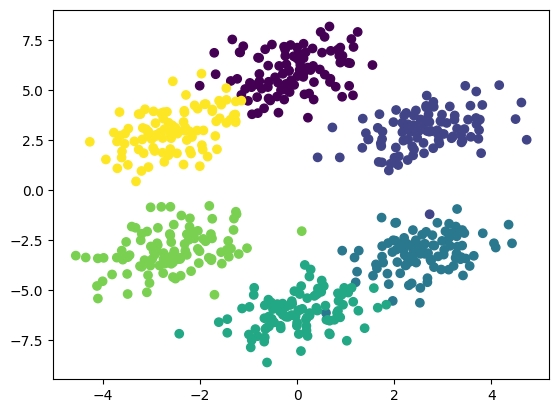

In [149]:
plt.scatter(hexagon["x"], hexagon["y"], c=hexagon["c"])

# Szerokość sąsiedztwa

In [13]:
widths = np.linspace(0.1, 1, 10)

In [200]:
widths = np.linspace(0.1, 1, 10)

num_trails = 10

scores = list(range(num_trails))
epochs = 60

labels = hexagon["c"].values

for trail in range(num_trails):
    print(f"Trail {trail}")
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    for width in widths:
        koh = KohonenNetwork(2, 3, GaussianNeighboringFunc(initial_neighbouring_radius=width), vec_dim=2)    
        koh.fit(hexagon[["x", "y"]].values, epochs, history=False, verbose=False)
        som_labels = koh.predict(hexagon[["x", "y"]].values, return_labels=True)
        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))
        
save_scores(scores, "neighbouring_widths")

Trail 0
Trail 1
Trail 2
Trail 3
Trail 4
Trail 5
Trail 6
Trail 7
Trail 8
Trail 9


In [9]:
scores = load_scores("neighbouring_widths")

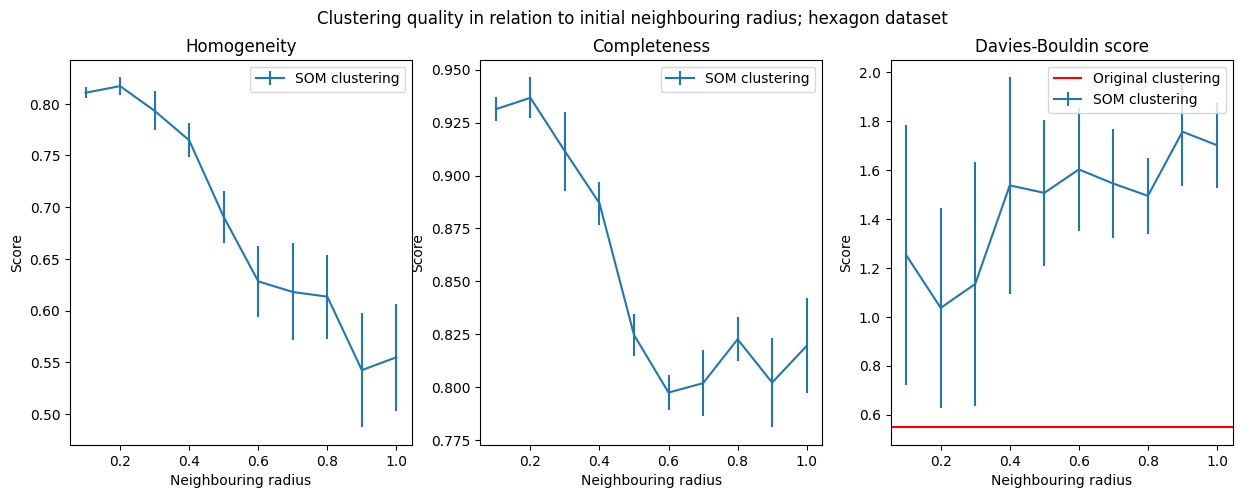

In [14]:
fig, axs = create_summary_plots(scores, widths, scores_start = 0, scores_end=len(widths), n_trials=10, errorevery=1, baseline=True, plot_title="Neighbouring radius", suptitle="Clustering quality in relation to initial neighbouring radius; hexagon dataset", save_path="neighbouring_radius")

plt.show()

## Neighbouring function


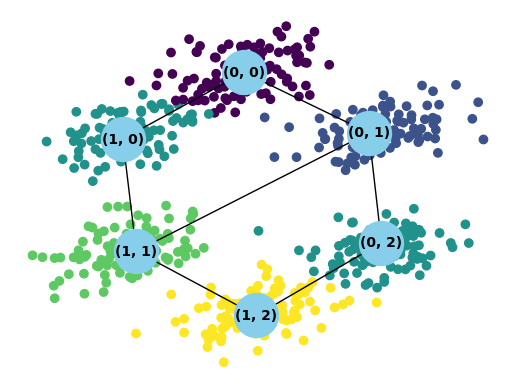

In [31]:
from som import MinusOneGaussianNeighboringFunc, MexicanSombreroNeighboringFunc, DistNeighboringFunc

koh = KohonenNetwork(2, 3, MinusOneGaussianNeighboringFunc(initial_neighbouring_radius=0.2), lambda_param=500, initial_learning_rate=0.1, init_method="random")

koh.fit(hexagon[["x", "y"]].values, 60, verbose=False, history=False)

labels = koh.predict(hexagon[["x", "y"]].values)
plt.scatter(hexagon["x"], hexagon["y"], c=labels)

koh.plot_graph()

In [18]:
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score

In [77]:
from som import MinusOneGaussianNeighboringFunc, MexicanSombreroNeighboringFunc, DistNeighboringFunc

In [78]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, MinusOneGaussianNeighboringFunc(initial_neighbouring_radius=0.2), lambda_param=10, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))
        
save_scores(scores, "neighbouring_function_minus_one")

Trail 0
Finished training in trail 0
Trail 1
Finished training in trail 1
Trail 2
Finished training in trail 2
Trail 3
Finished training in trail 3
Trail 4
Finished training in trail 4
Trail 5
Finished training in trail 5
Trail 6
Finished training in trail 6
Trail 7
Finished training in trail 7
Trail 8
Finished training in trail 8
Trail 9
Finished training in trail 9


In [81]:
minus_one_scores = load_scores("neighbouring_function_minus_one")

In [ ]:
M = 2
N = 3

max_epochs = 200
n_trials = 10

scores = list(range(n_trials))
labels = hexagon["c"].values

for trail in range(n_trials):
    scores[trail] = {"homogeneity": [], "completeness": [], "v_measure": [], "silhouette": [], "davies_bouldin": [], "calinski_harabasz": []}
    koh = KohonenNetwork(M, N, DistNeighboringFunc(initial_neighbouring_radius=0.2), lambda_param=10, initial_learning_rate=1)
    print(f"Trail {trail}")
    old_labels = koh.fit(hexagon[["x", "y"]].values, max_epochs, verbose = False, history=True)
    print(f"Finished training in trail {trail}")
    for epoch in range(1, max_epochs):
        som_labels = old_labels[epoch]

        scores[trail]["homogeneity"].append(homogeneity_score(hexagon["c"].values, som_labels))
        scores[trail]["completeness"].append(completeness_score(hexagon["c"].values, som_labels))
        scores[trail]["v_measure"].append(v_measure_score(hexagon["c"].values, som_labels))

        scores[trail]["silhouette"].append(silhouette_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["davies_bouldin"].append(davies_bouldin_score(hexagon[["x", "y"]].values, som_labels))
        scores[trail]["calinski_harabasz"].append(calinski_harabasz_score(hexagon[["x", "y"]].values, som_labels))
        
save_scores(scores, "neighbouring_function_dist")

In [94]:
gausian_scores = load_scores("neighbouring_function_dist")
minus_one_scores = load_scores("neighbouring_function_minus_one")

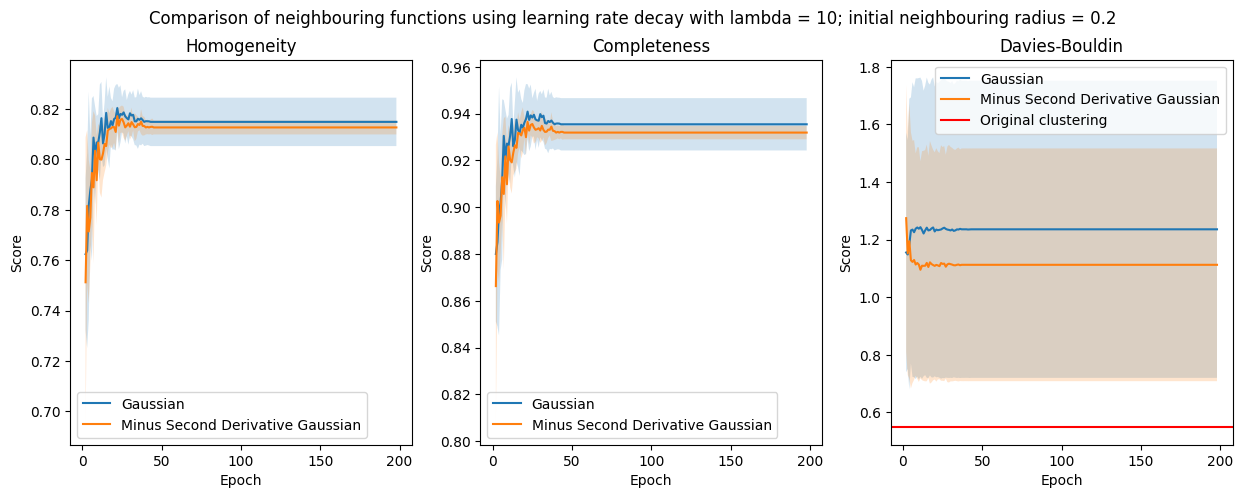

In [99]:
values = list(range(1, max_epochs))
scores_start = 1
scores_end = -1

errorbar = False
baseline = True

plot_title = "Epoch"
suptitle = "Comparison of neighbouring functions using learning rate decay with lambda = 10; initial neighbouring radius = 0.2"

mean_scores_gaussian = {key: np.mean([gausian_scores[trail][key] for trail in range(n_trials)], axis=0) for key in gausian_scores[0].keys()}
std_scores_gaussian = {key: np.std([gausian_scores[trail][key] for trail in range(n_trials)], axis=0) for key in gausian_scores[0].keys()}

mean_scores_derivative = {key: np.mean([minus_one_scores[trail][key] for trail in range(n_trials)], axis=0) for key in gausian_scores[0].keys()}
std_scores_derivative = {key: np.std([minus_one_scores[trail][key] for trail in range(n_trials)], axis=0) for key in gausian_scores[0].keys()}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(values[scores_start:scores_end], mean_scores_gaussian["homogeneity"][scores_start:scores_end], label="Gaussian"); axs[0].set_title("Homogeneity")
axs[1].plot(values[scores_start:scores_end], mean_scores_gaussian["completeness"][scores_start:scores_end], label="Gaussian"); axs[1].set_title("Completeness")
axs[2].plot(values[scores_start:scores_end], mean_scores_gaussian["davies_bouldin"][scores_start:scores_end], label="Gaussian"); axs[2].set_title("Davies-Bouldin")

axs[0].fill_between(values[scores_start:scores_end], mean_scores_gaussian["homogeneity"][scores_start:scores_end] - std_scores_gaussian["homogeneity"][scores_start:scores_end], mean_scores_gaussian["homogeneity"][scores_start:scores_end] + std_scores_gaussian["homogeneity"][scores_start:scores_end], alpha=0.2)
axs[1].fill_between(values[scores_start:scores_end], mean_scores_gaussian["completeness"][scores_start:scores_end] - std_scores_gaussian["completeness"][scores_start:scores_end], mean_scores_gaussian["completeness"][scores_start:scores_end] + std_scores_gaussian["completeness"][scores_start:scores_end], alpha=0.2)
axs[2].fill_between(values[scores_start:scores_end], mean_scores_gaussian["davies_bouldin"][scores_start:scores_end] - std_scores_gaussian["davies_bouldin"][scores_start:scores_end], mean_scores_gaussian["davies_bouldin"][scores_start:scores_end] + std_scores_gaussian["davies_bouldin"][scores_start:scores_end], alpha=0.2)
    
    
axs[0].plot(values[scores_start:scores_end], mean_scores_derivative["homogeneity"][scores_start:scores_end], label="Minus Second Derivative Gaussian"); axs[0].set_title("Homogeneity")
axs[1].plot(values[scores_start:scores_end], mean_scores_derivative["completeness"][scores_start:scores_end], label="Minus Second Derivative Gaussian"); axs[1].set_title("Completeness")
axs[2].plot(values[scores_start:scores_end], mean_scores_derivative["davies_bouldin"][scores_start:scores_end], label="Minus Second Derivative Gaussian"); axs[2].set_title("Davies-Bouldin")

axs[0].fill_between(values[scores_start:scores_end], mean_scores_derivative["homogeneity"][scores_start:scores_end] - std_scores_derivative["homogeneity"][scores_start:scores_end], mean_scores_derivative["homogeneity"][scores_start:scores_end] + std_scores_derivative["homogeneity"][scores_start:scores_end], alpha=0.2)
axs[1].fill_between(values[scores_start:scores_end], mean_scores_derivative["completeness"][scores_start:scores_end] - std_scores_derivative["completeness"][scores_start:scores_end], mean_scores_derivative["completeness"][scores_start:scores_end] + std_scores_derivative["completeness"][scores_start:scores_end], alpha=0.2)
axs[2].fill_between(values[scores_start:scores_end], mean_scores_derivative["davies_bouldin"][scores_start:scores_end] - std_scores_derivative["davies_bouldin"][scores_start:scores_end], mean_scores_derivative["davies_bouldin"][scores_start:scores_end] + std_scores_derivative["davies_bouldin"][scores_start:scores_end], alpha=0.2)
    


if baseline:
    axs[2].axhline(davies_bouldin_score(hexagon[['x', 'y']].values, hexagon["c"].values), c="red", label="Original clustering")
    
    
for j in range(3):
        
        axs[j].set_xlabel(plot_title)
        axs[j].set_ylabel("Score")
        axs[j].legend()


plt.suptitle(suptitle)

plt.savefig(Path("plots") / "neighbouring_functions_comparison.png")